In [3]:
import os
import sys
root_directory = os.getcwd()[0:3]
sys.path.append('E:\SCI\SCI9_1\10_Journals\03_Nature Food\code')
sys.path.append(r'C:\ProgramData\anaconda3\Lib\site-packages') 
sys.path.append(r'C:\Users\DELL\.conda\envs\myenv\Lib\site-packages') 
sys.path.append(r'C:\Users\DELL\.conda\envs\rasterio_env\Lib\site-packages') 
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from functions import plot_vis_correlation_with_yield1,plot_vis_correlation_with_yield,find_nearest_point_left_of_target
from scipy.signal import savgol_filter

root_directory = os.getcwd()[0:3]
crop = '02_wheat';
countryID ='06_India'
country =countryID[3:]
# inputpath_base = root_directory + '\\SCI\\SCI9\\2_DataAnalysis\\10_BuildModel0719\\'+crop+'\\'+countryID
inputpath_base = root_directory + '\\SCI\\SCI9_1\\02_data\\'+crop+'\\'+countryID
inpath_dates_other = root_directory + '\\SCI\\SCI9_1\\02_data\\'+crop+'\\'+countryID+'\\'+'01_data'+'\\'+'07_Information'
other_infornamtion = pd.read_csv(os.path.join(inpath_dates_other,'information.txt'), sep=' ', header=None)
startyear,endyear,shp_name = other_infornamtion.iloc[0,0],other_infornamtion.iloc[0,1],other_infornamtion.iloc[0,2]
yieldyear = startyear # 产量记录开始日期
years = range(startyear,endyear+1)

VIs =  [ '_KNDVI' ,'_EVI','_NDVI','_modis_Gpp','_Fpar','_modis_LAI','_PML_Gpp']
Cilmate = ['_Pre' ,'_Tmin' ,'_Solar','_Tmean','_Tmax']
Climate_Exogenous  = ['_CDD' ,'_HDD' ,'_GDD','_VPD','_wind_speed','_SPEI']
soil_feature = [ 'SAND','AWC', 'SILT','ORG_CARBON',  'TOTAL_N', 'PH_WATER',  'CEC_SOIL', 'CLAY']
loc_feature = ['elevation', 'lat', 'lon','Mean_Yield','Previous_Yield']
Year_feature = ['year'];union_feature = ['idJoin'];

46


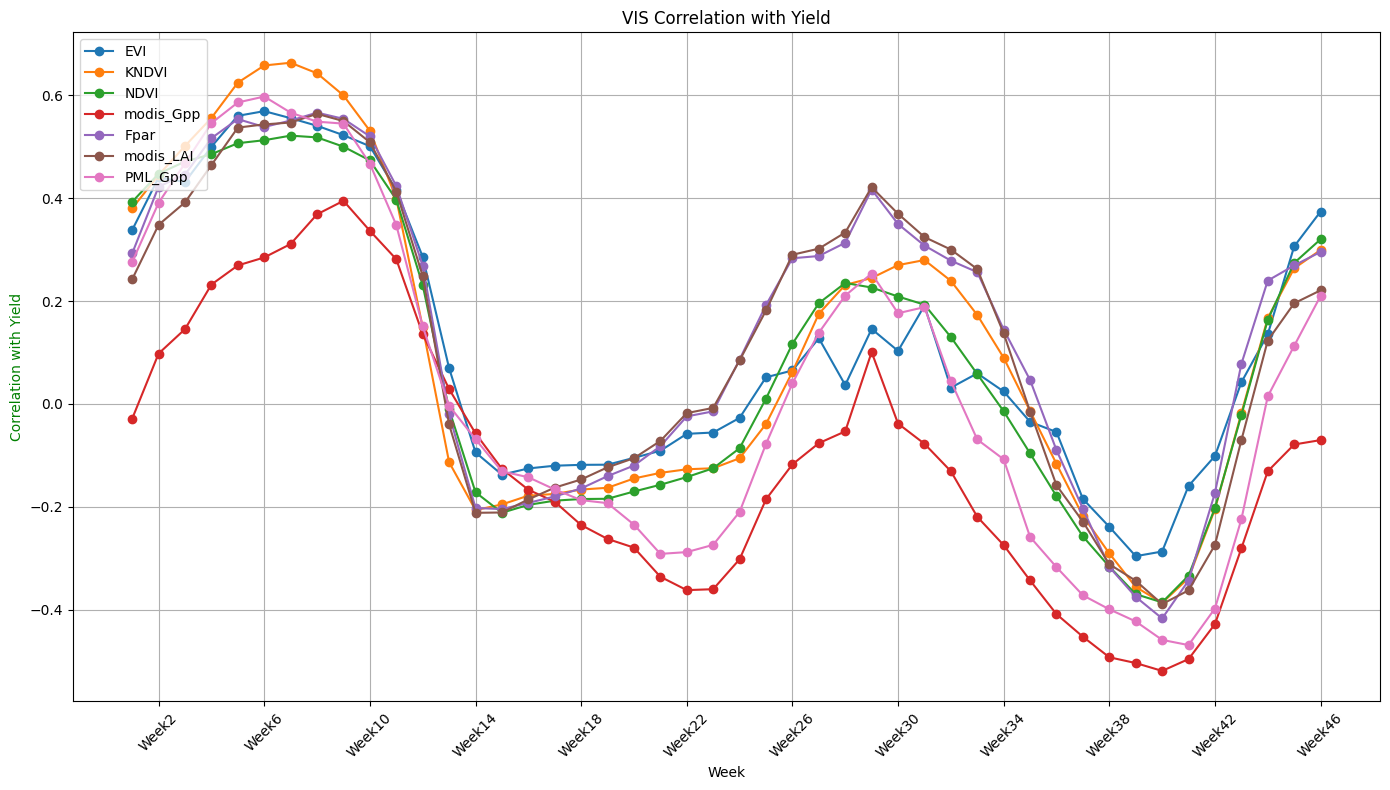

In [5]:
# USDA indicates that the growing season of winter wheat in India is from October to May (week 36 - week 19). Based on the plots generated by the plot_vis_correlation_with_yield function, it is found that during the growing season, especially the peak period, KNDVI has the highest correlation. Therefore, we select KNDVI as the optimal VI (optimum KNDVI)
regions = ['I']
VI_sel = {
    'I': '_KNDVI'
}
region ='I'

allweekYielddata =  os.path.join(inputpath_base, '01_data','05_buildmodel','01_weekdata',region+'_allweekYielddata.csv')
outpath_fig3 = os.path.join(inputpath_base, '06_figure', region+'_gs_VIs_R.jpg')
data_yield_ori_Visall = pd.read_csv(allweekYielddata)
data_yield_ori_Visall['Country'] = country
evi_data,kndvi_data,ndvi_data,modis_Gpp_data,Fpar_data,modis_LAI_data,PML_Gpp_data = plot_vis_correlation_with_yield(data_yield_ori_Visall, outpath_fig3)
VI_select2 = VI_sel[region];


# evi_data,kndvi_data,ndvi_data,modis_Gpp_data,Fpar_data,modis_LAI_data,PML_Gpp_data = plot_vis_correlation_with_yield(data_yield_ori_Visall, outpath_fig3)

In [ ]:
#.............................. First perform interpolation on the selected optimal data..............................
dataname = [f'Week{week}_{VI_select2[1:]}' for week in range(1, 47)]
data_VIS = data_yield_ori_Visall[dataname] 
data_VIS = data_VIS.apply(lambda row: row.fillna(row.rolling(5, min_periods=1, center=True).mean()), axis=1)
# Fill with adjacent values
data_VIS = data_VIS.fillna(method='bfill') 
data_VIS = data_VIS.fillna(method='ffill') 

#.............................. Perform filtering processing on the selected VIS..............................
for index, row in data_VIS.iterrows():
    # Apply Savitzky-Golay filter
    filtered_row = savgol_filter(row, window_length=5, polyorder=3, mode='interp')
    # Add the filtered row to the DataFrame
    data_VIS.loc[index,dataname] = filtered_row
data_yield_ori_Visall[dataname] = data_VIS

In [ ]:
######################### Find start, peak and harvest weeks ####################################3
# USDA indicates that the growing season of winter wheat in India is from October to May (week 36 - week 19), which corresponds to the second crop season, not the first crop season

mean_all_years = pd.DataFrame(data_VIS).mean()
filtered_mean_all_years = savgol_filter(mean_all_years, window_length=5, polyorder=3)
first_derivative  = savgol_filter(filtered_mean_all_years, window_length=5, polyorder=3, deriv=1)
second_derivative = savgol_filter(filtered_mean_all_years, window_length=5, polyorder=3, deriv=2)
mean_all_years.values

In [21]:
# Limit the period to week 36 - week 19 based on USDA's growing season
# Find the peak week of the modeling period
mean_all_years1 = pd.concat([mean_all_years.loc["Week36_KNDVI":"Week46_KNDVI"], mean_all_years.loc["Week1_KNDVI":"Week19_KNDVI"]])
max_point = int(mean_all_years1.idxmax()[4:5])
max_point # Represents the week, not the index; the index should be max_point - 1

6

In [57]:
# Harvest week: Since it is a double-cropping system (successive planting of the second crop), find the inflection point on the right side of the maximum value
# (within week 36 - week 19)
y= filtered_mean_all_years[max_point-1:19+1]
dy = np.diff(y)
# Find the position where the first derivative changes from negative to positive (sign change)
turn_idx = np.where(np.diff(np.sign(dy)) > 0)[0]

# Output results
print("First derivative：", dy)
print("Inflection point index (negative → positive change occurs after the previous point):", turn_idx)
if len(turn_idx) > 0:
    print("Original values corresponding to inflection points:", y[turn_idx + 1])
harvest_point = max_point+turn_idx #
harvest_point = harvest_point[0] # Represents the week, not the index; the index should be max_point - 1

一阶导数： [-0.00441829 -0.02526351 -0.04470746 -0.05690789 -0.05447266 -0.03946041
 -0.02077452 -0.00748746 -0.00089757  0.00120881  0.00166054  0.00204739
  0.00332791  0.0049855 ]
拐点索引（负→正变化发生在前一个点之后）: [8]
拐点对应的原始值: [0.09289297]


In [58]:
# Find harvest_point = int(y[turn_idx + 1].index[0][4:5])
# Select the data points on the left side of the maximum value. Since it is a double-cropping system, find the inflection point on the left side
y = pd.concat([mean_all_years.loc["Week36_KNDVI":"Week46_KNDVI"], mean_all_years.loc["Week1_KNDVI":"Week"+str(max_point)+"_KNDVI"]])
dy = np.diff(y)

# Find the position where the first derivative changes from negative to positive (sign change)
turn_idx = np.where(np.diff(np.sign(dy)) > 0)[0]

# Output results
print("First derivative:", dy)
print("Inflection point index (negative → positive change occurs after the previous point):", turn_idx)
if len(turn_idx) > 0:
    print("Original values corresponding to inflection points:", y[turn_idx + 1])
start_point = int(y[turn_idx + 1].index[0][4:6])

一阶导数： [-0.04901897 -0.04279835 -0.03574763 -0.02517634 -0.0142267  -0.00431279
  0.00673004  0.01799405  0.02441258  0.02183267  0.02820154  0.03698724
  0.03929867  0.03704961  0.02852896  0.01434505]
拐点索引（负→正变化发生在前一个点之后）: [5]
拐点对应的原始值: Week42_KNDVI    0.092289
dtype: float64


In [60]:
print(f'{region} Start period:{start_point}, Peak point:{max_point}, Harvest date:{harvest_point}') # These are week numbers, not indices

I开始期:42, 峰值点:6, 收获日期:14


In [62]:
VIs_eli = [item for item in VIs if item != VI_select2]

I开始期:42, 峰值点:6, 收获日期:14


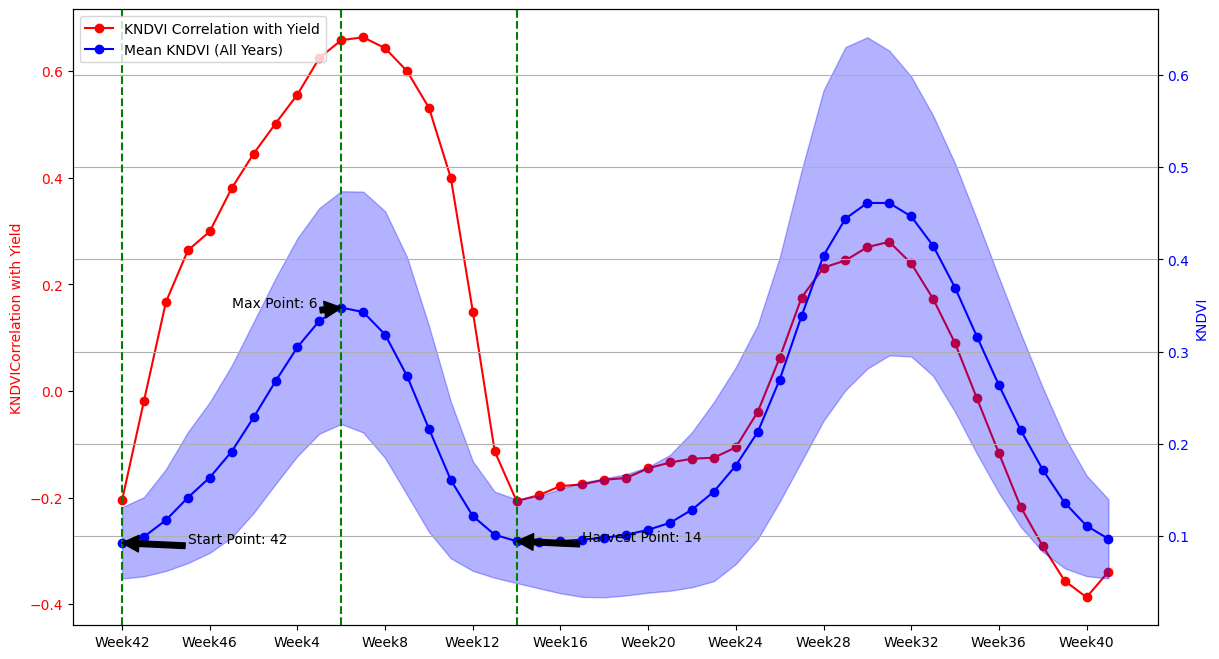

In [65]:
print(f'{region} Start period:{start_point}, Peak point:{max_point}, Harvest date:{harvest_point}') # These are week numbers, not indices
################################ Save data: Extracted growing season and data (only select the group with the highest correlation coefficient)
os.makedirs(os.path.join(inputpath_base, '01_data','05_buildmodel', '02_extractdates'), exist_ok=True)
outpath_dates = os.path.join(inputpath_base, '01_data','05_buildmodel', '02_extractdates','gs_three_periods.txt')
'''
with open(outpath_dates, 'a') as file:
    # 写入列名
    #file.write('plant\tpeak\tharvest\n')
    # 写入对应的值
    file.write(f'{start_point}\t{max_point}\t{harvest_point}\t{VI_select2}\t{region}\n')
'''
########################## Output processed data ##############################################
VIs_eli = [item for item in VIs if item != VI_select2]
outpath_data = os.path.join(inputpath_base, '01_data','05_buildmodel', '01_weekdata',region+'_allweekYielddata_VIs.csv')
selected_columns = [col for col in data_yield_ori_Visall.columns if all(feature not in col for feature in VIs_eli)]
data_yield_ori_Visall = data_yield_ori_Visall[selected_columns];
data_yield_ori_Visall.to_csv(outpath_data,index=False)


################################################### Handle cross-year scenarios for plotting ##########################################
parameter_VIs= {'_KNDVI': kndvi_data,'_EVI': evi_data,'_NDVI': ndvi_data,'_modis_Gpp':  modis_Gpp_data,'_modis_LAI': modis_LAI_data,'_PML_Gpp': PML_Gpp_data}
data_VI_r = parameter_VIs[VI_select2]
mean_all_years = pd.DataFrame(data_VIS).mean()
if harvest_point<start_point:
    last_ten = data_VI_r[start_point-1:]
    rest = data_VI_r[:start_point-1]
    data_VI_r = pd.concat([last_ten, rest])
    last_ten = mean_all_years[start_point-1:]
    rest = mean_all_years[:start_point-1]
    mean_all_years = pd.concat([last_ten, rest])
    start_point_correct=0;
    max_point_correct=max_point+len(list(range(start_point,47)))-1;
    harvest_point_correct=harvest_point+len(list(range(start_point,47)))-1;  
    last_ten = data_VIS.iloc[:,start_point-1:]
    rest = data_VIS.iloc[:,:start_point-1]
    data_VIS_new = pd.concat([last_ten, rest],axis=1)
else:
    start_point_correct=start_point-1;
    max_point_correct=max_point-1;
    harvest_point_correct=harvest_point-1;    
    data_VIS_new = data_VIS
mean_values = data_VIS_new.mean()
std_values = data_VIS_new.std()   

########################################## Plot correlation graph and growing season #################
outpath_fig2 = os.path.join(inputpath_base, '06_figure', region+'_gs_three_periods.jpg')
weeks = [f'Week{week}{VI_select2}' for week in range(1, 47)]
weeks_labels = [f'Week{week}' for week in range(1, 47)]
data = data_yield_ori_Visall[weeks + ['year', 'Yield', 'idJoin']]
data = data.dropna(subset=['Yield'])
# Group by year and idJoin, calculate correlation for each group
def calculate_correlations(group):
    return group.drop(['idJoin'],axis=1).corr()['year']
grouped = data.groupby(['idJoin'])
correlations = grouped.apply(calculate_correlations)

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_ylabel('Correlation with Yield', color='g')
x = mean_all_years.index.tolist()
x_label = [week.split('_')[0] for week in x]
# First Y-axis
data = correlations[weeks]
data.columns = x_label
mean = data.mean().values;std = data.std().values;
# Plot shaded area of mean ± standard deviation

#data.boxplot(column=x_label, ax=ax1, rot=90, showfliers=False)
ax1.plot(x_label, data_VI_r, marker='o', label=f'{VI_select2[1:]} Correlation with Yield', color='r')
ax1.set_ylabel(VI_select2[1:]+'Correlation with Yield', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()  # Second Y-axis
ax2.plot(x_label, mean_values.values,  marker='o', label='Mean '+VI_select2[1:]+' (All Years)', color='blue')
# Plot shaded area of mean ± standard deviation
ax2.fill_between(x_label, (mean_values - std_values).values, (mean_values + std_values), color='blue', alpha=0.3)


ax2.set_ylabel(VI_select2[1:], color='b')
ax2.tick_params(axis='y', labelcolor='b')

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

# Mark start point, peak point and harvest point
ax2.axvline(x=start_point_correct, color='g', linestyle='--', label='Start Point')
ax2.annotate(f'Start Point: {start_point}', xy=(start_point_correct, mean_all_years[start_point_correct]), 
             xytext=(start_point_correct + 3, mean_all_years[start_point_correct] + 0.00002),
             arrowprops=dict(facecolor='black', shrink=0.00002))

ax2.axvline(x=max_point_correct, color='g', linestyle='--', label='Max Week')
ax2.annotate(f'Max Point: {max_point}', xy=(max_point_correct, mean_all_years[max_point_correct]), 
             xytext=(max_point_correct -5, mean_all_years[max_point_correct] + 0.00009),# 0.02
             arrowprops=dict(facecolor='black', shrink=0.00002))

ax2.axvline(x=harvest_point_correct, color='g', linestyle='--', label='Harvest Week')
ax2.annotate(f'Harvest Point: {harvest_point}', xy=(harvest_point_correct, mean_all_years[harvest_point_correct]), 
             xytext=(harvest_point_correct +3, mean_all_years[harvest_point_correct] + 0.00002),
             arrowprops=dict(facecolor='black', shrink=0.00002))
xticks= [week.split('_')[0] for week in x]
plt.xticks(xticks[::4], rotation=90)  # Display every 4th tick
plt.grid(True)

plt.savefig(outpath_fig2)
plt.show()

array([-0.0236676 , -0.0392145 , -0.05012526, -0.05370036, -0.05146926,
       -0.04635754, -0.03956728, -0.03052392, -0.01997569, -0.00932019,
        0.00148977,  0.01293716,  0.02191078,  0.02392229,  0.01967419])